In [1]:
import torch
import torch.nn as nn
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

/opt/anaconda3/envs/taelor-backend/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


reference: https://pytorch-geometric.readthedocs.io/en/latest/tutorial/heterogeneous.html

### Creating Heterogeneous Graph

In [56]:
data = HeteroData()

num_users = 30
num_items = 100
num_features_user = 9
num_features_item = 12
num_transactions = 200

data["user"].x = torch.rand((num_users, num_features_user))
data["item"].x = torch.rand((num_items, num_features_item))

data["user", "buys", "item"].edge_index = torch.stack(
    [
        torch.randint(high=num_users, size=(num_transactions,)),
        torch.randint(high=num_items, size=(num_transactions,)),
    ]
)

data["user", "buys", "item"].y = torch.randint(
    low=1, high=6, size=(num_transactions,)
).to(torch.float)

data = T.ToUndirected()(data)

print(data)

HeteroData(
  user={ x=[30, 9] },
  item={ x=[100, 12] },
  (user, buys, item)={
    edge_index=[2, 200],
    y=[200]
  },
  (item, rev_buys, user)={
    edge_index=[2, 200],
    y=[200]
  }
)


### Graph Visualization

In [57]:
from torch_geometric.utils import to_networkx
import networkx as nx
from torch_geometric.data import Data
import matplotlib.pyplot as plt


def hetero_to_homo_graph(hetero_graph):
    graph = Data()
    num_users = hetero_graph["user"].x.shape[0]
    num_items = hetero_graph["item"].x.shape[0]
    graph.x = torch.rand((num_users + num_items, 1))
    graph.edge_index = hetero_graph["user", "buys", "item"].edge_index
    graph.edge_index[1, :] += num_users
    node_colors = ["red" for _ in range(num_users)] + ["blue" for _ in range(num_items)]
    nx_graph = to_networkx(graph)
    return nx_graph, node_colors, None


def hetero_to_bipartite_graph(hetero_graph):
    G = nx.Graph()
    num_users = hetero_graph["user"].x.shape[0]
    num_items = hetero_graph["item"].x.shape[0]
    nodes_set1 = [i for i in range(num_users)]
    nodes_set2 = [i for i in range(num_items)]
    G.add_nodes_from(nodes_set1, bipartite=0)
    G.add_nodes_from(nodes_set2, bipartite=1)
    edge_index = hetero_graph["user", "buys", "item"].edge_index
    edges = [
        (edge_index[0][i].item(), edge_index[1][i].item())
        for i in range(edge_index.shape[1])
    ]
    G.add_edges_from(edges)
    pos = nx.bipartite_layout(G, nodes_set1)
    node_colors = ["red" for _ in range(num_users)] + ["blue" for _ in range(num_items)]
    return G, None, pos


def visualize_graph(hetero_graph, graph_type="homo"):
    if graph_type == "homo":
        nx_graph, node_colors, pos = hetero_to_homo_graph(hetero_graph)
    elif graph_type == "bipartite":
        nx_graph, node_colors, pos = hetero_to_bipartite_graph(hetero_graph)
    print(nx_graph)
    plt.figure(1, figsize=(8, 8))
    nx.draw(
        nx_graph,
        pos=pos,
        node_size=10,
        linewidths=1,
        node_color=node_colors,
    )
    plt.show()

DiGraph with 130 nodes and 192 edges


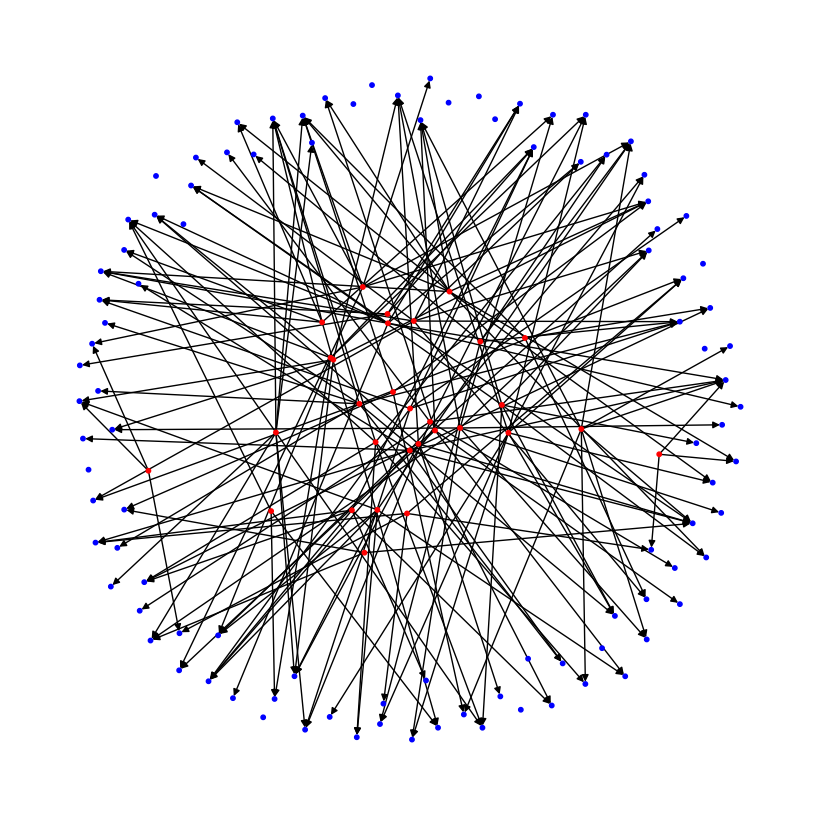

In [59]:
visualize_graph(data, graph_type="homo")

Graph with 100 nodes and 190 edges


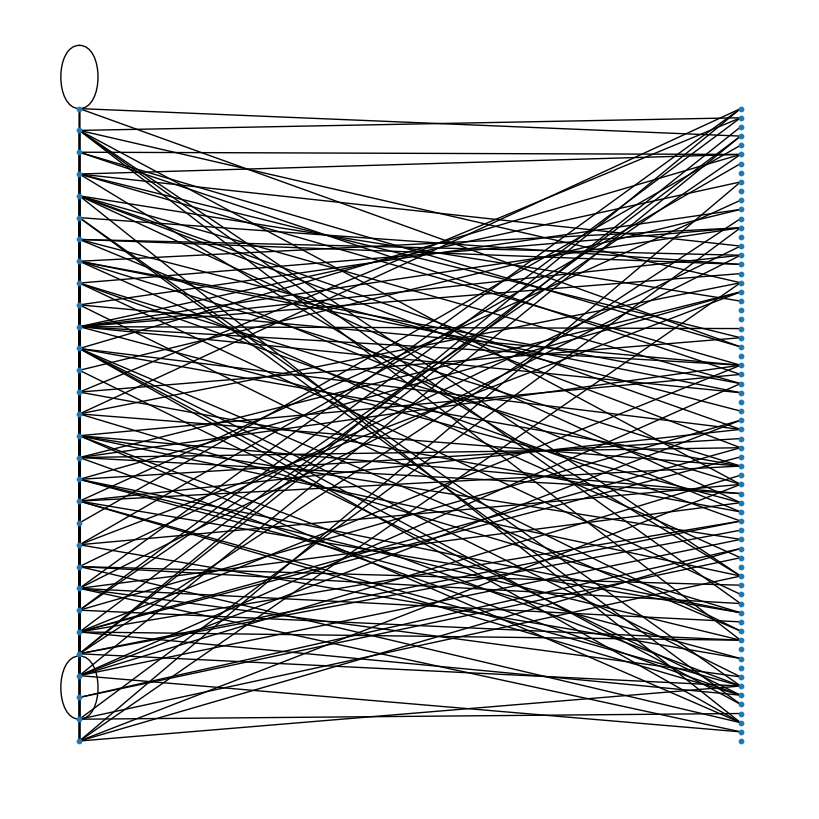

In [58]:
visualize_graph(data, graph_type="bipartite")

### Data Splitting

In [3]:
import random
from torch_geometric.utils import index_to_mask
from torch_geometric.utils import select


def edge_splitting(data: HeteroData, split_ratio=[0.7, 0.2, 0.1]) -> HeteroData:
    edge_num = data["user", "buys", "item"].edge_index.shape[1]
    edge_idxs = list(range(edge_num))
    random.shuffle(edge_idxs)

    # split edge index
    train_ratio, valid_ratio, test_ratio = split_ratio
    assert (
        abs(train_ratio + valid_ratio + test_ratio - 1.0) < 1e-3
    ), "The sum ratio of train/valid/test should be 1!"
    train_num = int(edge_num * train_ratio)
    valid_num = int(edge_num * valid_ratio)
    test_num = edge_num - train_num - valid_num
    train_index = torch.tensor(edge_idxs[:train_num])
    valid_index = torch.tensor(edge_idxs[train_num:-test_num])
    test_index = torch.tensor(edge_idxs[-test_num:])

    # convert index to mask
    train_mask = index_to_mask(train_index, size=edge_num)
    valid_mask = index_to_mask(valid_index, size=edge_num)
    test_mask = index_to_mask(test_index, size=edge_num)
    assert torch.all((train_mask + valid_mask + test_mask + 0) == torch.ones(edge_num))
    data["user", "buys", "item"].train_mask = train_mask
    data["user", "buys", "item"].valid_mask = valid_mask
    data["user", "buys", "item"].test_mask = test_mask

    # split the label y on edges
    data["user", "buys", "item"].y_train = select(
        data["user", "buys", "item"].y,
        index_or_mask=data["user", "buys", "item"].train_mask,
        dim=0,
    )
    data["user", "buys", "item"].y_valid = select(
        data["user", "buys", "item"].y,
        index_or_mask=data["user", "buys", "item"].valid_mask,
        dim=0,
    )
    data["user", "buys", "item"].y_test = select(
        data["user", "buys", "item"].y,
        index_or_mask=data["user", "buys", "item"].test_mask,
        dim=0,
    )

    return data

In [4]:
data = edge_splitting(data, [0.7, 0.2, 0.1])
print(data)

HeteroData(
  user={ x=[100, 9] },
  item={ x=[1000, 12] },
  (user, buys, item)={
    edge_index=[2, 1000],
    y=[1000],
    train_mask=[1000],
    valid_mask=[1000],
    test_mask=[1000],
    y_train=[700],
    y_valid=[200],
    y_test=[100]
  },
  (item, rev_buys, user)={
    edge_index=[2, 1000],
    y=[1000]
  }
)


### Creating Heterogeneous GNNs
PyG provides three ways to create models on heterogenrous graph data:
1. `torch_geometric.nn.to_hetero()` to convert model
2. `conv.HeteroConv` to define individual functions for different types
3. Deploy existing heterogeneous GNN operators

For me, the second one is more clear and easy to understand, so I will use it in the following exampe.

In [5]:
from torch_geometric.nn import HeteroConv, SAGEConv, GATv2Conv


class HeteroGNN(torch.nn.Module):
    def __init__(self, user_dim, item_dim, hidden_dim, num_layers):
        super().__init__()

        self.lin_proj_user = nn.Linear(user_dim, hidden_dim)
        self.lin_proj_item = nn.Linear(item_dim, hidden_dim)

        self.convs = nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv(
                {
                    ("user", "buys", "item"): GATv2Conv(
                        (hidden_dim, hidden_dim),
                        hidden_dim,
                        heads=2,
                        concat=False,
                        add_self_loops=False,
                    ),
                    ("item", "rev_buys", "user"): GATv2Conv(
                        (hidden_dim, hidden_dim),
                        hidden_dim,
                        heads=2,
                        concat=False,
                        add_self_loops=False,
                    ),
                }
            )
            self.convs.append(conv)

        self.edge_embedding_mlp = torch.nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),
        )

    def forward(
        self, x_dict, edge_index_dict, message_passing_edge_mask, target_edge_mask
    ):
        # linear projections
        for node_type, x in x_dict.items():
            if node_type == "user":
                x_dict[node_type] = self.lin_proj_user(x)
            elif node_type == "item":
                x_dict[node_type] = self.lin_proj_item(x)

        # message passing mask is used for GNN message passing
        message_passing_edge_index_dict = {}
        for edge_type, edge_index in edge_index_dict.items():
            message_passing_edge_index_dict[edge_type] = select(
                edge_index,
                index_or_mask=message_passing_edge_mask,
                dim=1,
            )

        # message passing convolutions
        for conv in self.convs:
            x_dict = conv(x_dict, message_passing_edge_index_dict)
            x_dict = {node_type: x.relu() for node_type, x in x_dict.items()}

        # target mask is used for final target prediction
        # for example, in validation stage,
        # messge_passing_edge_mask = train_mask + valid_mask
        # target_edge_mask = valid_mask
        target_edge_index_dict = {}
        for edge_type, edge_index in edge_index_dict.items():
            target_edge_index_dict[edge_type] = select(
                edge_index,
                index_or_mask=target_edge_mask,
                dim=1,
            )

        # edge embedding calculation
        index_i, index_j = target_edge_index_dict[("user", "buys", "item")]
        user_embedding_i = x_dict["user"][index_i]
        item_embedding_j = x_dict["item"][index_j]
        edge_embedding = torch.cat([user_embedding_i, item_embedding_j], dim=1)
        edge_output = self.edge_embedding_mlp(edge_embedding).squeeze()

        return edge_output


model_kwargs = {
    "user_dim": num_features_user,
    "item_dim": num_features_item,
    "hidden_dim": 64,
    "num_layers": 1,
}
model = HeteroGNN(**model_kwargs)
print(model)

HeteroGNN(
  (lin_proj_user): Linear(in_features=9, out_features=64, bias=True)
  (lin_proj_item): Linear(in_features=12, out_features=64, bias=True)
  (convs): ModuleList(
    (0): HeteroConv(num_relations=2)
  )
  (edge_embedding_mlp): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


### Train the GNN model

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = torch.nn.MSELoss()

In [7]:
def train():
    model.train()
    edge_prediction = model(
        data.x_dict,
        data.edge_index_dict,
        message_passing_edge_mask=data["user", "buys", "item"].train_mask,
        target_edge_mask=data["user", "buys", "item"].train_mask,
    )
    loss = criterion(edge_prediction, data["user", "buys", "item"].y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss.item()

In [8]:
@torch.no_grad()
def test(mode="valid"):
    model.eval()

    if mode == "valid":
        message_passing_edge_mask = (
            data["user", "buys", "item"].train_mask
            + data["user", "buys", "item"].valid_mask
        )
        target_edge_mask = data["user", "buys", "item"].valid_mask
        y = data["user", "buys", "item"].y_valid

    elif mode == "test":
        message_passing_edge_mask = (
            data["user", "buys", "item"].train_mask
            + data["user", "buys", "item"].valid_mask
            + data["user", "buys", "item"].test_mask
        )
        target_edge_mask = data["user", "buys", "item"].test_mask
        y = data["user", "buys", "item"].y_test

    edge_prediction = model(
        data.x_dict,
        data.edge_index_dict,
        message_passing_edge_mask=message_passing_edge_mask,
        target_edge_mask=target_edge_mask,
    )
    loss = criterion(edge_prediction, y)

    return loss.item()

In [9]:
train_loss_record = []
valid_loss_record = []
test_loss_record = []
for _ in range(50):
    train_loss = train()
    valid_loss = test(mode="valid")
    test_loss = test(mode="test")
    print("loss:", train_loss, valid_loss, test_loss)
    train_loss_record.append(train_loss)
    valid_loss_record.append(valid_loss)
    test_loss_record.append(test_loss)

loss: 10.716692924499512 9.577590942382812 10.188158988952637
loss: 9.380799293518066 7.3546223640441895 7.921782970428467
loss: 7.21359920501709 4.291996479034424 4.7723541259765625
loss: 4.249305725097656 1.9389609098434448 2.214446783065796
loss: 2.0639138221740723 4.868930339813232 4.790042877197266
loss: 5.192019939422607 3.4877212047576904 3.5016868114471436
loss: 3.7687628269195557 2.0146684646606445 2.2034506797790527
loss: 2.19281005859375 2.128236770629883 2.45086932182312
loss: 2.2098522186279297 2.80021333694458 3.1959378719329834
loss: 2.821308135986328 3.2304370403289795 3.6568076610565186
loss: 3.2248687744140625 3.250209331512451 3.679365873336792
loss: 3.2424232959747314 2.9371416568756104 3.3476903438568115
loss: 2.9457199573516846 2.4532430171966553 2.8239684104919434
loss: 2.495154857635498 2.0324621200561523 2.3422293663024902
loss: 2.120666742324829 1.9095730781555176 2.1464474201202393
loss: 2.0491394996643066 2.1044509410858154 2.268929958343506
loss: 2.28886532

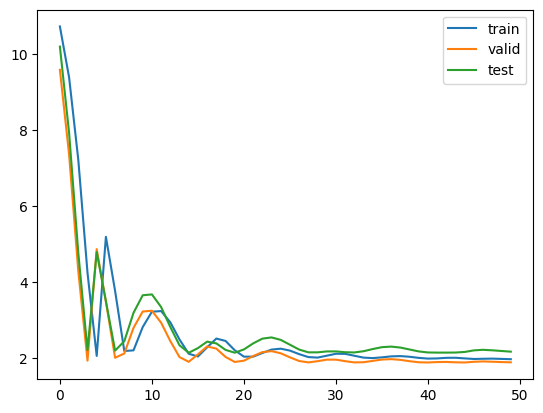

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_loss_record, label="train")
plt.plot(valid_loss_record, label="valid")
plt.plot(test_loss_record, label="test")
plt.legend()
plt.show()